# **Imports**

In [ ]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.layers import Dense, Dropout, Embedding, LSTM, GRU
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import SimpleRNN,Bidirectional
from keras.callbacks import EarlyStopping
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from prettytable import PrettyTable


# **Loading data**

In [ ]:
df = pd.read_csv('/content/weather_prediction_dataset.csv')
df

,DATE,MONTH,BASEL_cloud_cover,BASEL_humidity,BASEL_pressure,BASEL_global_radiation,BASEL_precipitation,BASEL_sunshine,BASEL_temp_mean,BASEL_temp_min,...,STOCKHOLM_temp_min,STOCKHOLM_temp_max,TOURS_wind_speed,TOURS_humidity,TOURS_pressure,TOURS_global_radiation,TOURS_precipitation,TOURS_temp_mean,TOURS_temp_min,TOURS_temp_max
0,20000101,1,8,0.89,1.0286,0.20,0.03,0.0,2.9,1.6,...,-9.3,0.7,1.6,0.97,1.0275,0.25,0.04,8.5,7.2,9.8
1,20000102,1,8,0.87,1.0318,0.25,0.00,0.0,3.6,2.7,...,0.5,2.0,2.0,0.99,1.0293,0.17,0.16,7.9,6.6,9.2
2,20000103,1,5,0.81,1.0314,0.50,0.00,3.7,2.2,0.1,...,-1.0,2.8,3.4,0.91,1.0267,0.27,0.00,8.1,6.6,9.6
3,20000104,1,7,0.79,1.0262,0.63,0.35,6.9,3.9,0.5,...,2.5,4.6,4.9,0.95,1.0222,0.11,0.44,8.6,6.4,10.8
4,20000105,1,5,0.90,1.0246,0.51,0.07,3.7,6.0,3.8,...,-1.8,2.9,3.6,0.95,1.0209,0.39,0.04,8.0,6.4,9.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3649,20091228,12,7,0.82,1.0084,0.28,0.42,0.3,3.2,1.0,...,-2.7,2.4,3.7,0.95,1.0011,0.22,1.50,6.2,1.8,10.6
3650,20091229,12,7,0.92,1.0028,0.22,1.68,0.2,4.5,2.4,...,-9.5,0.8,5.3,0.89,0.9966,0.24,0.40,10.4,6.2,14.5
3651,20091230,12,8,0.92,0.9979,0.07,1.54,0.0,8.5,7.5,...,-12.5,-7.4,3.8,0.88,0.9939,0.24,1.00,10.0,8.7,11.3
3652,20091231,12,7,0.93,0.9958,0.17,0.57,0.1,6.6,4.3,...,-9.3,-6.5,4.2,0.88,0.9933,0.58,0.02,8.5,6.2,10.9


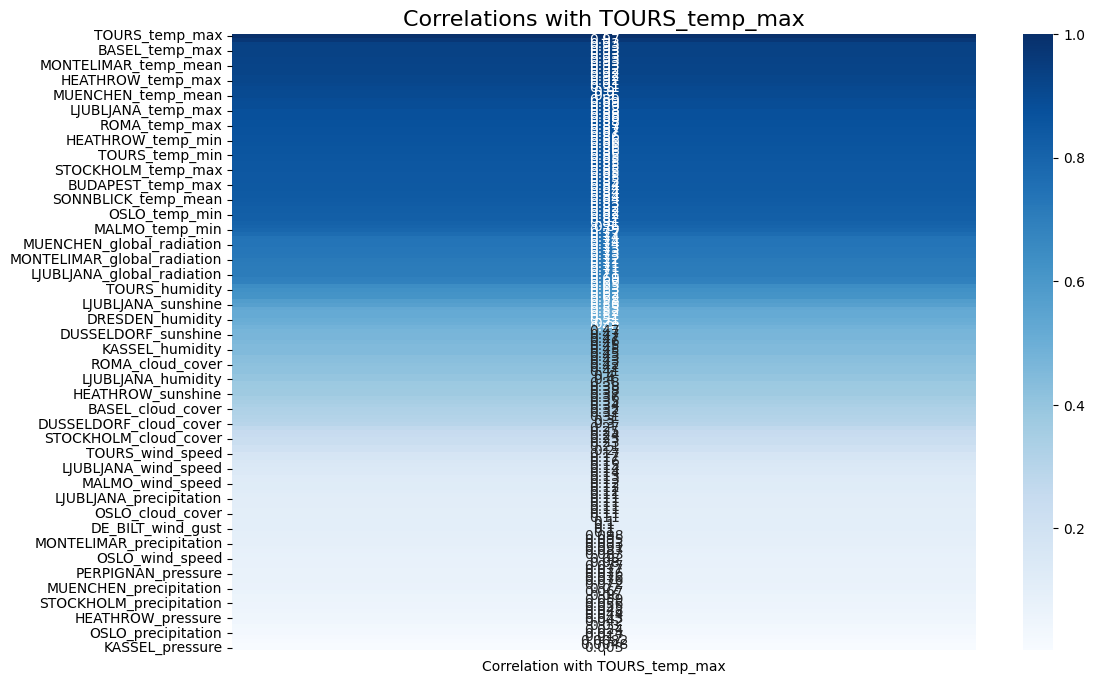

In [ ]:
col_name = 'TOURS_temp_max'

# Get the correlations between the chosen column and all other columns in the DataFrame
corr_with_col = df.corrwith(df[col_name], method='spearman')

# Create a new DataFrame with the correlations and sort by absolute value
corr_df = pd.DataFrame({'Correlation with {}'.format(col_name): corr_with_col.abs()})
corr_df = corr_df.sort_values(by='Correlation with {}'.format(col_name), ascending=False)

# Create a heatmap of the correlations
plt.figure(figsize=(12, 8))
sns.heatmap(corr_df, cmap='Blues', annot=True)
plt.title('Correlations with {}'.format(col_name), fontsize=16)
plt.show()

In [ ]:
corr_df[0:17]

,Correlation with TOURS_temp_max
TOURS_temp_max,1.000000
TOURS_temp_mean,0.972665
MONTELIMAR_temp_max,0.934043
MAASTRICHT_temp_max,0.933532
BASEL_temp_max,0.932320
HEATHROW_temp_mean,0.931922
BASEL_temp_mean,0.929692
MAASTRICHT_temp_mean,0.928109
MONTELIMAR_temp_mean,0.925208
DUSSELDORF_temp_max,0.923948


# **Splitting**

In [ ]:
df['year'] = df['DATE'].apply(lambda x: int(str(x)[:4]))

train_df = df[df['year'].isin(range(2000, 2008))]
valid_df = df[df['year'].isin(range(2008, 2010))]


In [ ]:
# Select the desired columns
cols = ['TOURS_temp_mean', 'MONTELIMAR_temp_max', 'MAASTRICHT_temp_max', 'BASEL_temp_max',
        'HEATHROW_temp_mean', 'BASEL_temp_mean', 'MAASTRICHT_temp_mean', 'MONTELIMAR_temp_mean',
        'DUSSELDORF_temp_max', 'DE_BILT_temp_max', 'DUSSELDORF_temp_mean', 'HEATHROW_temp_max',
        'DE_BILT_temp_mean', 'KASSEL_temp_max', 'KASSEL_temp_mean','TOURS_temp_max']

# Modify train_df and valid_df to select the desired columns
train_df = train_df[cols]
valid_df = valid_df[cols]

train_df=train_df.values
valid_df=valid_df.values

In [ ]:
train_df

array([[ 8.5,  8.5,  6.9, ...,  5. ,  3.5,  9.8],
       [ 7.9,  9.8,  7.5, ...,  4.7,  2.3,  9.2],
       [ 8.1,  8.5,  7.9, ...,  4.6,  3.5,  9.6],
       ...,
       [ 6.1, 10. ,  6.7, ...,  2.9,  0.7,  9.3],
       [ 2.8,  9.1,  7.1, ...,  4.4,  3.3,  4.5],
       [ 4.2,  8.2,  5.5, ...,  4. ,  1.7,  6.1]])

In [ ]:
train_df[:, -1]

array([9.8, 9.2, 9.6, ..., 9.3, 4.5, 6.1])

# **Models**

In [ ]:
def get_rnn_model(step_size, n_features):
    model = Sequential()
    model.add(SimpleRNN(units=64, input_shape=(step_size, n_features), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(units=1))
    model.compile(optimizer='adam', loss='mean_squared_error')
    return model


def get_gru_model(step_size, n_features):
    model = Sequential()
    model.add(GRU(units=64, input_shape=(step_size, n_features), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model


def get_lstm_model(step_size, n_features):
    model = Sequential()
    model.add(LSTM(units=64, input_shape=(step_size, n_features), activation='relu'))
    model.add(Dropout(0.2))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error', optimizer='adam')
    return model

In [ ]:
# Train the models with early stopping based on validation data loss
early_stop = EarlyStopping(monitor='val_loss', patience=10)

for step_size in [25, 5, 15]:
    print(f"Training models for step size: {step_size}")
    train_X, train_y = [], []
    valid_X, valid_y = [], []

    for i in range( len(train_df)-step_size):
        train_X.append(train_df[i:i+step_size, :-1])
        train_y.append(train_df[i+step_size, -1])

    for i in range(len(valid_df)-(step_size)):
        valid_X.append(valid_df[i:i+step_size, :-1])
        valid_y.append(valid_df[i+step_size, -1])

    train_X, train_y = np.array(train_X), np.array(train_y)
    valid_X, valid_y = np.array(valid_X), np.array(valid_y)
    # RNN model
    print("RNN Model:")
    rnn_model = get_rnn_model(step_size, n_features=15)
    rnn_model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(valid_X, valid_y), callbacks=[early_stop])

    # GRU model
    print("GRU Model:")
    gru_model = get_gru_model(step_size, n_features=15)
    gru_model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(valid_X, valid_y), callbacks=[early_stop])

    # LSTM model
    print("LSTM Model:")
    lstm_model = get_lstm_model(step_size, n_features=15)
    lstm_model.fit(train_X, train_y, epochs=100, batch_size=16, validation_data=(valid_X, valid_y), callbacks=[early_stop])

Training models for step size: 25
RNN Model:
Epoch 1/100
182/182 [==============================] - 5s 19ms/step - loss: 44.8986 - val_loss: 8.5745
Epoch 2/100
182/182 [==============================] - 4s 20ms/step - loss: 16.3866 - val_loss: 8.2587
Epoch 3/100
182/182 [==============================] - 4s 19ms/step - loss: 14.0316 - val_loss: 7.6109
Epoch 4/100
182/182 [==============================] - 3s 17ms/step - loss: 12.7885 - val_loss: 8.4387
Epoch 5/100
182/182 [==============================] - 3s 17ms/step - loss: 13.1043 - val_loss: 7.7228
Epoch 6/100
182/182 [==============================] - 4s 23ms/step - loss: 11.7647 - val_loss: 7.0969
Epoch 7/100
182/182 [==============================] - 3s 16ms/step - loss: 11.4332 - val_loss: 6.8176
Epoch 8/100
182/182 [==============================] - 3s 16ms/step - loss: 11.0452 - val_loss: 7.8675
Epoch 9/100
182/182 [==============================] - 3s 17ms/step - loss: 10.9173 - val_loss: 7.0718
Epoch 10/100
182/182 [======

Epoch 1/100
182/182 [==============================] - 12s 52ms/step - loss: 32.2357 - val_loss: 8.4192
Epoch 2/100
182/182 [==============================] - 10s 56ms/step - loss: 12.7038 - val_loss: 7.6673
Epoch 3/100
182/182 [==============================] - 10s 57ms/step - loss: 12.0222 - val_loss: 6.9747
Epoch 4/100
182/182 [==============================] - 10s 57ms/step - loss: 12.0923 - val_loss: 7.8527
Epoch 5/100
182/182 [==============================] - 10s 57ms/step - loss: 11.3562 - val_loss: 7.2909
Epoch 6/100
182/182 [==============================] - 11s 58ms/step - loss: 11.5873 - val_loss: 6.7665
Epoch 7/100
182/182 [==============================] - 9s 50ms/step - loss: 11.7707 - val_loss: 6.6830
Epoch 8/100
182/182 [==============================] - 10s 57ms/step - loss: 11.2577 - val_loss: 7.6687
Epoch 9/100
182/182 [==============================] - 11s 58ms/step - loss: 10.5436 - val_loss: 6.7235
Epoch 10/100
182/182 [==============================] - 11s 62ms/

Epoch 1/100
182/182 [==============================] - 10s 47ms/step - loss: 33.8429 - val_loss: 7.8990
Epoch 2/100
182/182 [==============================] - 7s 39ms/step - loss: 16.1452 - val_loss: 10.9842
Epoch 3/100
182/182 [==============================] - 8s 46ms/step - loss: 15.6195 - val_loss: 7.0706
Epoch 4/100
182/182 [==============================] - 8s 46ms/step - loss: 13.9666 - val_loss: 7.1611
Epoch 5/100
182/182 [==============================] - 7s 38ms/step - loss: 13.3384 - val_loss: 8.7854
Epoch 6/100
182/182 [==============================] - 8s 46ms/step - loss: 12.9376 - val_loss: 7.6002
Epoch 7/100
182/182 [==============================] - 8s 45ms/step - loss: 12.7875 - val_loss: 6.9101
Epoch 8/100
182/182 [==============================] - 7s 39ms/step - loss: 13.2514 - val_loss: 6.7312
Epoch 9/100
182/182 [==============================] - 8s 46ms/step - loss: 11.8860 - val_loss: 7.1543
Epoch 10/100
182/182 [==============================] - 8s 42ms/step - 

GRU Model:
Epoch 1/100
183/183 [==============================] - 6s 22ms/step - loss: 21.9555 - val_loss: 7.4958
Epoch 2/100
183/183 [==============================] - 3s 14ms/step - loss: 13.1179 - val_loss: 6.9881
Epoch 3/100
183/183 [==============================] - 3s 14ms/step - loss: 11.9520 - val_loss: 7.9204
Epoch 4/100
183/183 [==============================] - 3s 14ms/step - loss: 11.6628 - val_loss: 6.8159
Epoch 5/100
183/183 [==============================] - 4s 21ms/step - loss: 11.1010 - val_loss: 7.3856
Epoch 6/100
183/183 [==============================] - 3s 14ms/step - loss: 10.9685 - val_loss: 8.0188
Epoch 7/100
183/183 [==============================] - 3s 14ms/step - loss: 10.7946 - val_loss: 7.8581
Epoch 8/100
183/183 [==============================] - 3s 14ms/step - loss: 10.4995 - val_loss: 6.9647
Epoch 9/100
183/183 [==============================] - 3s 19ms/step - loss: 10.3251 - val_loss: 7.1375
Epoch 10/100
183/183 [==============================] - 3s 15m

LSTM Model:
Epoch 1/100
183/183 [==============================] - 5s 14ms/step - loss: 29.0562 - val_loss: 7.9010
Epoch 2/100
183/183 [==============================] - 2s 12ms/step - loss: 14.9883 - val_loss: 8.3024
Epoch 3/100
183/183 [==============================] - 2s 12ms/step - loss: 14.2732 - val_loss: 6.8372
Epoch 4/100
183/183 [==============================] - 2s 12ms/step - loss: 14.0078 - val_loss: 7.0038
Epoch 5/100
183/183 [==============================] - 3s 16ms/step - loss: 13.0316 - val_loss: 6.8861
Epoch 6/100
183/183 [==============================] - 3s 14ms/step - loss: 12.2840 - val_loss: 6.7462
Epoch 7/100
183/183 [==============================] - 2s 12ms/step - loss: 12.5914 - val_loss: 7.2463
Epoch 8/100
183/183 [==============================] - 2s 11ms/step - loss: 12.1250 - val_loss: 6.6811
Epoch 9/100
183/183 [==============================] - 2s 12ms/step - loss: 11.8028 - val_loss: 6.4044
Epoch 10/100
183/183 [==============================] - 2s 12

GRU Model:
Epoch 1/100
182/182 [==============================] - 8s 33ms/step - loss: 33.3728 - val_loss: 9.5195
Epoch 2/100
182/182 [==============================] - 7s 40ms/step - loss: 15.8171 - val_loss: 7.5588
Epoch 3/100
182/182 [==============================] - 6s 32ms/step - loss: 12.9799 - val_loss: 8.2136
Epoch 4/100
182/182 [==============================] - 7s 40ms/step - loss: 12.3448 - val_loss: 7.7339
Epoch 5/100
182/182 [==============================] - 6s 33ms/step - loss: 12.5058 - val_loss: 6.9701
Epoch 6/100
182/182 [==============================] - 7s 41ms/step - loss: 11.2486 - val_loss: 6.7455
Epoch 7/100
182/182 [==============================] - 7s 37ms/step - loss: 11.1230 - val_loss: 7.9872
Epoch 8/100
182/182 [==============================] - 6s 34ms/step - loss: 11.3652 - val_loss: 9.2595
Epoch 9/100
182/182 [==============================] - 7s 37ms/step - loss: 10.9762 - val_loss: 7.4499
Epoch 10/100
182/182 [==============================] - 6s 32m

LSTM Model:
Epoch 1/100
182/182 [==============================] - 8s 34ms/step - loss: 39.7595 - val_loss: 10.2422
Epoch 2/100
182/182 [==============================] - 5s 26ms/step - loss: 18.1550 - val_loss: 7.2763
Epoch 3/100
182/182 [==============================] - 6s 32ms/step - loss: 14.8431 - val_loss: 8.2691
Epoch 4/100
182/182 [==============================] - 5s 26ms/step - loss: 13.6953 - val_loss: 9.6229
Epoch 5/100
182/182 [==============================] - 6s 32ms/step - loss: 12.8745 - val_loss: 6.7497
Epoch 6/100
182/182 [==============================] - 5s 25ms/step - loss: 12.9931 - val_loss: 8.2431
Epoch 7/100
182/182 [==============================] - 5s 25ms/step - loss: 12.6912 - val_loss: 7.4318
Epoch 8/100
182/182 [==============================] - 6s 33ms/step - loss: 12.5679 - val_loss: 6.5375
Epoch 9/100
182/182 [==============================] - 5s 26ms/step - loss: 11.7786 - val_loss: 7.0649
Epoch 10/100
182/182 [==============================] - 6s 3

In [ ]:
table = PrettyTable()
table.field_names = ["Step Size", "EpochsRNN","EpochsGRU","EpochsLSTM", "RNN Validation Loss", "GRU Validation Loss", "LSTM Validation Loss"]

table.add_row([25, 33 ,21 ,18  , 6.6671, 7.0944, 7.2395])
table.add_row([5, 22,39,27 , 7.0955, 6.8665,6.6700])
table.add_row([15, 28,26,26 , 6.9105, 6.7125, 6.6296])

print(table)

+-----------+-----------+-----------+------------+---------------------+---------------------+----------------------+
| Step Size | EpochsRNN | EpochsGRU | EpochsLSTM | RNN Validation Loss | GRU Validation Loss | LSTM Validation Loss |
+-----------+-----------+-----------+------------+---------------------+---------------------+----------------------+
|     25    |     33    |     21    |     18     |        6.6671       |        7.0944       |        7.2395        |
|     5     |     22    |     39    |     27     |        7.0955       |        6.8665       |         6.67         |
|     15    |     28    |     26    |     26     |        6.9105       |        6.7125       |        6.6296        |
+-----------+-----------+-----------+------------+---------------------+---------------------+----------------------+


#**Conclusion**

**- The LSTM model performed better than the RNN and GRU models in terms of validation loss for all step sizes, according to the findings of our experiment.**

**- In addition, we found that the best number of epochs for each model varied with step size. The RNN model had the most epochs (33 and 28, respectively) for step sizes of 25 and 15, whereas the GRU model had the fewest epochs (21 and 26, respectively). The GRU model had the most epochs (39) while the RNN model had the lowest number of epochs (22), for a step size of 5**

**- Additionally, we discovered that each model's performance was significantly impacted by early stopping. Early stopping allowed the models to avoid overfitting and achieve better performance on the validation set. For all models and step sizes, early stopping resulted in lower validation loss compared to not using early stopping.**

**- Also when we do normalization the loss was greater than without normalization**